In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

from google.cloud import bigquery
import google.cloud.bigquery.magics

google.cloud.bigquery.magics.context.use_bqstorage_api = True
%load_ext google.cloud.bigquery

### Setup of google credentials and connecting to the project

In [2]:
path_to_service_account_json = "./gcp_key.json"  # gcp_key.json - service account key, should be placed for individual account.
project_id = 'poetic-glass-297209'               # id of the project on google cloud platform, required for the authentification.

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=path_to_service_account_json 
client = bigquery.Client(project=project_id)

### Exploring dataset structure, columns, information in the columns

Information about columns adn datatypes is available on website: https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy

In [3]:
# sample dataframe for understanding datastructure
df = client.query('SELECT * FROM bigquery-public-data.iowa_liquor_sales.sales LIMIT 1000').to_dataframe()

In [4]:
df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,INV-21768300027,2019-09-09,2190,"Central City Liquor, Inc.",1460 2ND AVE,Des Moines,50314,POINT (-93.619787 41.60566),77,POLK,...,44487,Cruzan Dark,12,1000,8.39,12.59,2,25.18,2.00,0.52
1,S29395200028,2015-12-01,2465,Sid's Beverage Shop,2727 DODGE ST,DUBUQUE,52003,POINT (-90.705328 42.491862),31,Dubuque,...,2140,Hennessy VS 750ml + VSOP 50ml Chain VAP,6,800,18.99,28.49,2,56.98,1.60,0.42
2,S33626500042,2016-07-28,5102,Wilkie Liquors,724 1st St SE,Mount Vernon,52314,POINT (-91.410401 41.918328),57,Linn,...,86251,Juarez Triple Sec,12,1000,2.42,3.63,60,217.80,60.00,15.85
3,INV-00062700078,2016-08-31,2619,Hy-Vee Wine and Spirits / WDM,1725 74th St,West Des Moines,50266,POINT (-93.808855 41.598515),77,POLK,...,37994,Smirnoff Vodka 80 Prf,24,375,4.75,7.13,1,171.12,0.37,0.09
4,S33756200027,2016-08-08,4461,QUIK TRIP #503 / WINDSOR HEIGHTS,7220 Hickman Rd,Windsor Heights,50324,POINT (-93.717442 41.614647),77,Polk,...,56195,Paul Masson Peach Grande Amber Brandy,24,375,3.22,4.83,7,33.81,2.62,0.69


In [5]:
%%bigquery --use_rest_api number_of_rows
SELECT COUNT(*) AS n_rows FROM bigquery-public-data.iowa_liquor_sales.sales

In [6]:
print(f'Number of rows in dataset: {number_of_rows.loc[0,"n_rows"]}\nNumber of columns in dataset: {df.shape[1]}')

Number of rows in dataset: 18334221
Number of columns in dataset: 24


The dataset contains almost 20 million rows of data.  
Processing such datasets on a personal pc is not effective, so the analysis will be performed using SQL queries to google server and working with smaller batches of data.

In [7]:
print(df.columns)

Index(['invoice_and_item_number', 'date', 'store_number', 'store_name',
       'address', 'city', 'zip_code', 'store_location', 'county_number',
       'county', 'category', 'category_name', 'vendor_number', 'vendor_name',
       'item_number', 'item_description', 'pack', 'bottle_volume_ml',
       'state_bottle_cost', 'state_bottle_retail', 'bottles_sold',
       'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons'],
      dtype='object')


**Columns of interest:**  
- date - Date of order  
- sore_number - Unique number assigned to the store who ordered the liquor  
- city - City where the store who ordered the liquor is located
- store_location - Location of store who ordered the liquor. The Address, City, State and Zip Code are geocoded to provide geographic coordinates.  
- country - County where the store who ordered the liquor is located
- category_name - Category of the liquor ordered.
- vendor_name - The vendor number of the company for the brand of liquor ordered
- item_description - Description of the individual liquor product ordered  
- pack - The number of bottles in a case for the liquor ordered  
- bottle_volume_ml - Volume of each liquor bottle ordered in milliliters  
- state_bottle_cost - The amount that Alcoholic Beverages Division paid for each bottle of liquor ordered
- state_bottle_retail - The amount the store paid for each bottle of liquor ordered   
- bottles_sold - The number of bottles of liquor ordered by the store
- sale_dollars - Total cost of liquor order (number of bottles multiplied by the state bottle retail)
- volume_sold_liters - Total volume of liquor ordered in liters. (i.e. (Bottle Volume (ml) x Bottles Sold)/1,000)

There are several categorical fields (store name, city, country, etc.).  
Below, will be determined how many of unique items in each field

In [8]:
cat_field = ['store_name', 'city', 'county', 'category_name', 'vendor_name', 'item_description',
                   'pack', 'bottle_volume_ml']

In [9]:
stat = {}
for item in cat_field:
    sql = f'''
    SELECT {item},
    COUNT({item}) AS Number_of_transactions
    FROM bigquery-public-data.iowa_liquor_sales.sales
    GROUP BY 1
    ORDER BY 2 DESC
    '''
    stat[item] = client.query(sql).to_dataframe()
print(stat['city'].head())

           city  Number_of_transactions
0    DES MOINES                  810741
1    Des Moines                  795266
2  CEDAR RAPIDS                  597307
3  Cedar Rapids                  595081
4     DAVENPORT                  410786


Above we can see, that there are similar fields with a different cases.  
In order to have fair statistics, such fields should be converted into a single format and grouped again.

In [10]:
top_10 = {}
for item in cat_field:
    
    # Grouped cities in different cases
    try:
        stat[item][item] = stat[item][item].str.lower()
        stat[item] = stat[item].groupby(by=[item]).sum().sort_values(
            by='Number_of_transactions', ascending=False).reset_index()
    except:
        pass #Exceptin will be on numerical fields
    
    # Selected top 10 items
    top_10[item] = stat[item].head(10)
    top_10_number = round(top_10[item].Number_of_transactions.sum(),0)
    
    # General statistics for number of transactions
    statistics = stat[item].describe(percentiles=[0.1, 0.25, 0.5, .75, .9])
    
    print(f'\n{item}:')
    print(f'Number of unique values: {round(statistics.loc["count"].values[0],0)}')
    print(f'Average number of transactions: {round(statistics.loc["mean"].values[0],0)}')
    print(f'Number of transactions for 10 percentile: {round(statistics.loc["10%"].values[0],0)}')
    print(f'Number of transactions for 50 percentile: {round(statistics.loc["50%"].values[0],0)}')
    print(f'Number of transactions for 90 percentile: {round(statistics.loc["90%"].values[0],0)}')
    print(f'Number of transactions for top 10 items: {top_10_number} (which is {round(top_10_number/number_of_rows.loc[0,"n_rows"]*100,2)}% of total number)')      


store_name:
Number of unique values: 2602.0
Average number of transactions: 7046.0
Number of transactions for 10 percentile: 128.0
Number of transactions for 50 percentile: 2062.0
Number of transactions for 90 percentile: 16959.0
Number of transactions for top 10 items: 1088812 (which is 5.94% of total number)

city:
Number of unique values: 456.0
Average number of transactions: 40032.0
Number of transactions for 10 percentile: 514.0
Number of transactions for 50 percentile: 7802.0
Number of transactions for 90 percentile: 78028.0
Number of transactions for top 10 items: 7274152 (which is 39.68% of total number)

county:
Number of unique values: 104.0
Average number of transactions: 174787.0
Number of transactions for 10 percentile: 24960.0
Number of transactions for 50 percentile: 74074.0
Number of transactions for 90 percentile: 272917.0
Number of transactions for top 10 items: 10211306 (which is 55.7% of total number)

category_name:
Number of unique values: 109.0
Average number of

_____________

### Analysis of the data

- Hystorical trend and seasonality

In [11]:
%%time
sql = '''
SELECT 
    EXTRACT(YEAR FROM date) AS year,
    EXTRACT(MONTH FROM date) AS month,
    SUM(state_bottle_cost) AS state_bottle_cost,
    SUM(state_bottle_retail) AS state_bottle_retail,
    SUM(bottles_sold) AS bottles_sold,
    SUM(sale_dollars) AS sale_dolars,
    SUM(volume_sold_liters) AS volume_sold,
FROM bigquery-public-data.iowa_liquor_sales.sales
GROUP BY 1, 2
'''

sales_by_ym = client.query(sql).to_dataframe()

Wall time: 984 ms


In [12]:
sales_by_ym = sales_by_ym.sort_values(by=['year', 'month'])
sales_by_ym['period'] = sales_by_ym.year.astype(str) +"-"+ sales_by_ym.month.astype(str)
sales_by_ym.index = sales_by_ym.period

In [13]:
years = sales_by_ym.groupby(by=['year']).agg({'sale_dolars':'sum', 'volume_sold':'sum'})
months = sales_by_ym.groupby(by=['month']).agg({'sale_dolars':'mean', 'volume_sold':'mean'})

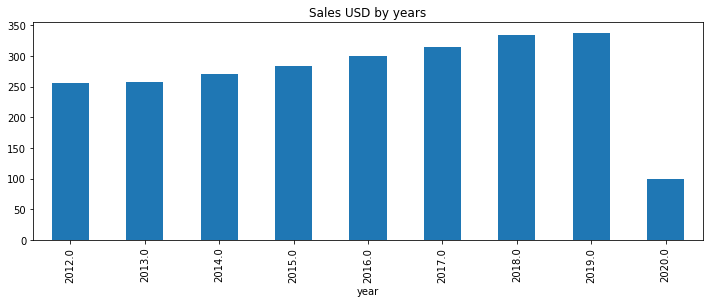

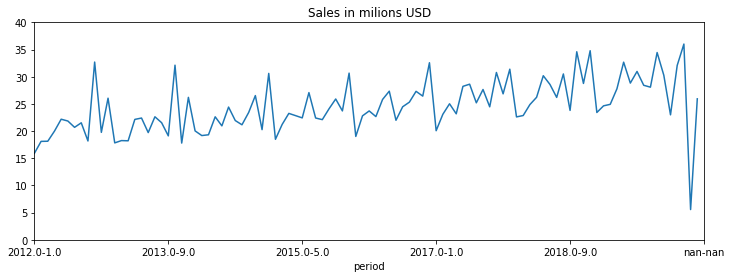

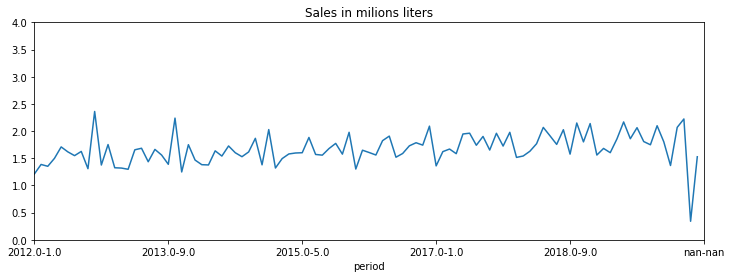

In [14]:
(years.sale_dolars/1000000).plot.bar(figsize=(12,4))
plt.title('Sales USD by years')
plt.show()

(sales_by_ym.sale_dolars/1000000).plot(figsize=(12,4))
plt.title('Sales in milions USD')
plt.ylim(0, 40)
plt.show()

(sales_by_ym.volume_sold/1000000).plot(figsize=(12,4))
plt.title('Sales in milions liters')
plt.ylim(0,4)
plt.show()

From the chart above, we can see growing trend over years in both USD and litres and some variations for months.  
Please see table below for pct changes year over year

_2020 is still in progress_

In [15]:
round(years.pct_change()*100,4)

,sale_dolars,volume_sold
year,,
2012.0,NaN,NaN
2013.0,1.1348,-0.9594
2014.0,4.8376,3.1392
2015.0,5.0788,2.3994
2016.0,5.3685,3.5314
2017.0,5.0387,3.9255
2018.0,6.1765,3.7077
2019.0,1.0448,-1.2269
2020.0,-70.4877,-71.4984


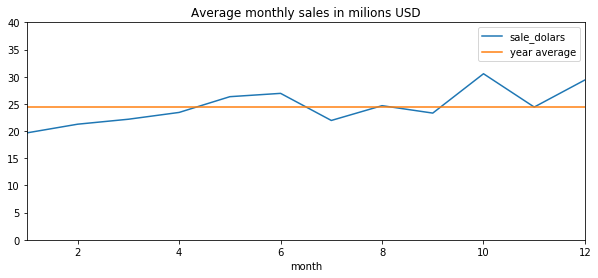

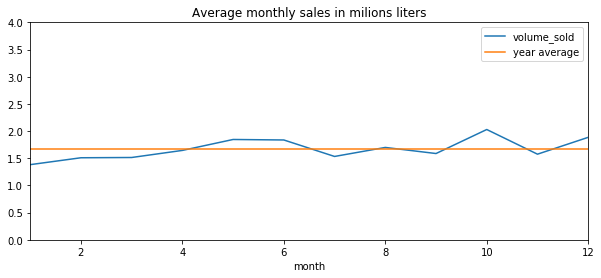

In [16]:
(months.sale_dolars/1000000).plot(figsize=(10,4))
plt.title('Average monthly sales in milions USD')
plt.plot([(months.sale_dolars/1000000).mean()]*13, label = 'year average')
plt.ylim(0, 40)
plt.legend()
plt.show()

(months.volume_sold/1000000).plot(figsize=(10,4))
plt.plot([(months.volume_sold/1000000).mean()]*13, label = 'year average')
plt.title('Average monthly sales in milions liters')
plt.ylim(0,4)
plt.legend()
plt.show()

In [17]:
# Deviation from  mean value:
print('Deviation of average montly revenue from year average')
print(round(months.sale_dolars / months.sale_dolars.mean()*100,2))

Deviation of average montly revenue from year average
month
1.0      80.26
2.0      86.77
3.0      90.49
4.0      95.60
5.0     107.41
6.0     109.90
7.0      89.57
8.0     100.66
9.0      95.10
10.0    124.63
11.0     99.63
12.0    119.98
Name: sale_dolars, dtype: float64


**Seasonality**  
From the chart above, we can see that October and December are months with maximum volume.  
Also, May and June show an increase in sales, however, it is less significant than above mentioned months.  
The lowest volume shows the first quarter of the year.  
  
Conclusion: seasonality exists and should be considered in business planning processes.

_____________________

##### Stores analysis
- Revenue concentration by stores  
- Top gainers  
- Top losers

In [18]:
%%time
sql = '''
SELECT 
    EXTRACT(YEAR FROM date) AS year,
    store_name,
    SUM(state_bottle_cost) AS state_bottle_cost,
    SUM(state_bottle_retail) AS state_bottle_retail,
    SUM(bottles_sold) AS bottles_sold,
    SUM(sale_dollars) AS sale_dolars,
    SUM(volume_sold_liters) AS volume_sold,
FROM bigquery-public-data.iowa_liquor_sales.sales
GROUP BY 1, 2
'''

sales_by_ym_stores = client.query(sql).to_dataframe()

Wall time: 2.38 s


In [19]:
sales_by_ym_stores['store_name'] = sales_by_ym_stores['store_name'].str.lower()

In [20]:
stores_pivot = sales_by_ym_stores.pivot_table(index='store_name', columns='year', values='sale_dolars', aggfunc=sum).fillna(0).sort_values(
    by=2020, ascending=False)

Below, will be analyzed revenue share of top 10 stores for 2020. 

In [21]:
stores_pivot.head(10)

year,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
store_name,,,,,,,,,
central city 2,595264.29,7337079.98,7955353.76,8742764.83,9331221.97,10113528.88,10526107.02,11505337.01,1853903.32
hy-vee #3 / bdi / des moines,8866541.94,8718451.37,9248505.59,9839393.08,10311583.19,10575119.32,11074051.37,10885938.89,1613847.06
costco wholesale #788 / wdm,0.00,0.00,0.00,0.00,0.00,0.00,2801675.96,3055715.58,1196554.26
hy-vee wine and spirits / iowa city,3388919.89,3481456.72,3866876.85,4155665.47,4424016.29,4716000.21,4584842.07,4842806.83,916913.73
hy-vee wine and spirits / wdm,1691098.74,1332129.17,1411306.69,1646447.23,1806484.93,1967935.47,2218696.01,2248874.03,693019.73
"central city liquor, inc.",7376698.34,969511.14,1323441.72,1228571.74,1472957.28,1569202.60,1752278.45,2022535.35,674648.39
hy-vee #3 food & drugstore / davenport,0.00,0.00,0.00,0.00,0.00,133878.89,1995884.74,1708775.66,663923.70
wilkie liquors,2350732.53,2048153.02,1784583.27,2087515.67,2617138.14,3024727.67,3258534.10,3563048.00,648242.64
hy-vee / waukee,0.00,534155.06,1141552.32,1382083.41,1738198.69,1944954.17,2251627.54,2239593.20,647270.04


In [22]:
top_10_shares_2020 = round(stores_pivot[2020] / years.loc[2020, 'sale_dolars']*100,2)

In [23]:
print(top_10_shares_2020.head(10))
print(f'\n Revenue share for top 10 stores: {top_10_shares_2020.head(10).sum()}%')

store_name
central city 2                            1.86
hy-vee #3 / bdi / des moines              1.62
costco wholesale #788 / wdm               1.20
hy-vee wine and spirits / iowa city       0.92
hy-vee wine and spirits / wdm             0.70
central city liquor, inc.                 0.68
hy-vee #3 food & drugstore / davenport    0.67
wilkie liquors                            0.65
hy-vee / waukee                           0.65
benz distributing                         0.64
Name: 2020.0, dtype: float64

 Revenue share for top 10 stores: 9.590000000000002%


There is no revenue concentration on single store. For 2020 year to date, maximum share of revenue for single store is about 2.2%. 

Next, we will find the top 5 stores by revenue increase and top 5 by revenue decrease during the period 2018 - 2019.  
Such information might be useful for finding opportunities and threads in customer structure.

In [24]:
stores_pivot['pct_change_18_19'] = round(stores_pivot[2019] / stores_pivot[2018] -1, 4) * 100
# Will be selected only stores with sales in 2018 and 2019
selected_stores = stores_pivot[(stores_pivot[2018] != 0)&(stores_pivot[2019] != 0)]

In [25]:
print(f'Top 5 stores by revenue INCREASE: \n')
print(selected_stores.sort_values(by='pct_change_18_19', ascending=False)[[2018, 2019, 'pct_change_18_19']].head(5))
print()
print(f'Top 5 stores by revenue DECREASE: \n')
print(selected_stores.sort_values(by='pct_change_18_19', ascending=False)[[2018, 2019, 'pct_change_18_19']].tail(5))

Top 5 stores by revenue INCREASE: 

year                                 2018.0     2019.0  pct_change_18_19
store_name                                                              
one stop shop #3 / algona             45.00  131879.72         292966.04
price chopper  /  beaver #1310     12118.48  274565.99           2165.68
westside petro                      3460.74   63536.20           1735.91
jiffy #926 / spirit lake           16084.76  286864.53           1683.46
price chopper  /  merle hay #1315  28505.97  410635.32           1340.52

Top 5 stores by revenue DECREASE: 

year                                           2018.0    2019.0  \
store_name                                                        
williamsburg foods                          155071.53  12126.21   
quillins quality foods postville             29757.13   2254.54   
keystone liquor & wine / coralville         319758.13  22642.77   
smokin' joe's #3 tobacco and liquor outlet  139513.49   8521.63   
smokin' joe's 

_____________________

### The most popular bottle volume

In [26]:
%%time
sql = '''
SELECT 
    EXTRACT(YEAR FROM date) AS year,
    bottle_volume_ml,
    SUM(bottles_sold) AS bottles_sold,
    SUM(sale_dollars) AS sale_dolars,
    SUM(volume_sold_liters) AS volume_sold,
FROM bigquery-public-data.iowa_liquor_sales.sales
GROUP BY 1, 2
'''

sales_by_bottles_y = client.query(sql).to_dataframe()

Wall time: 1.04 s


In [27]:
bottles_pivot = sales_by_bottles_y.pivot_table(index='bottle_volume_ml', columns='year', values='bottles_sold', aggfunc=sum).fillna(0)

In [28]:
total_bottles_sold_19 = bottles_pivot[2019].sum()
i = 1
for idx, row in bottles_pivot.sort_values(by=2019, ascending=False).head().iterrows():
    print(f'{i}. Bottle size - {idx}ml: sold in 2019: {row[2019]} ({round(row[2019]/total_bottles_sold_19 * 100,2)}%)')
    i += 1

1. Bottle size - 750.0ml: sold in 2019: 8665508.0 (33.35%)
2. Bottle size - 1000.0ml: sold in 2019: 4714614.0 (18.14%)
3. Bottle size - 1750.0ml: sold in 2019: 4690916.0 (18.05%)
4. Bottle size - 375.0ml: sold in 2019: 3088192.0 (11.88%)
5. Bottle size - 100.0ml: sold in 2019: 2069673.0 (7.97%)


In [29]:
bottles_pivot_shares = bottles_pivot / bottles_pivot.sum()

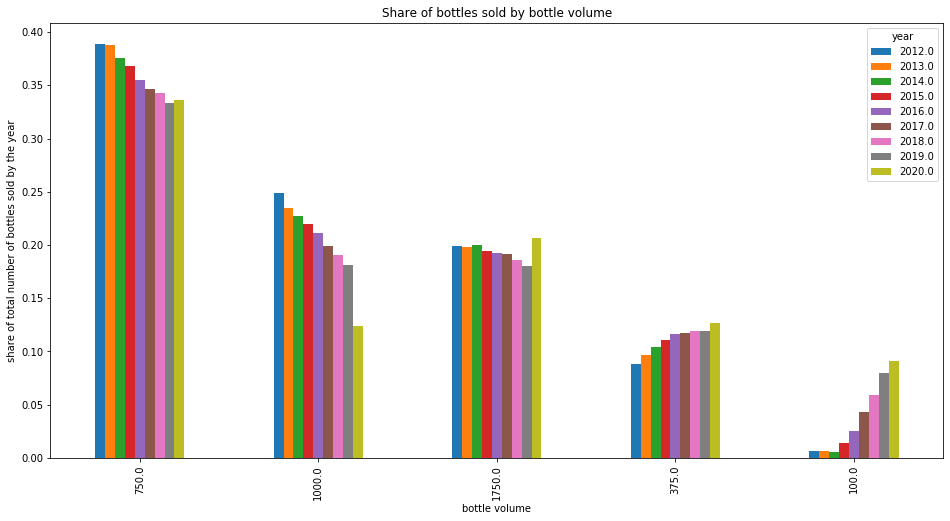

In [30]:
bottles_pivot_shares.sort_values(by=2019, ascending=False).head().plot.bar(figsize=(16,8))
plt.title('Share of bottles sold by bottle volume')
plt.xlabel('bottle volume')
plt.ylabel('share of total number of bottles sold by the year')
plt.show()

From the chart above, we can see that the most popular bottle volume is 750ml, however, the trend of such format is in decline (the similar situation for the second most popular format - 1000 ml)  
At the same time, we can see that smaller volumes (100ml and 375ml) are becoming more popular.


### Top items by volume sold

In [31]:
%%time
sql = '''
SELECT 
    EXTRACT(YEAR FROM date) AS year,
    item_description,
    SUM(bottles_sold) AS bottles_sold,
    SUM(sale_dollars) AS sale_dolars,
    SUM(volume_sold_liters) AS volume_sold,
FROM bigquery-public-data.iowa_liquor_sales.sales
GROUP BY 1, 2
'''

sales_by_items_y = client.query(sql).to_dataframe()

Wall time: 3.13 s


In [32]:
sales_by_items_y.item_description = sales_by_items_y.item_description.str.lower()
items_pivot = sales_by_items_y.dropna().pivot_table(index='item_description', columns='year', values='volume_sold', aggfunc=sum)\
    .fillna(0).sort_values(by=2019, ascending=False)

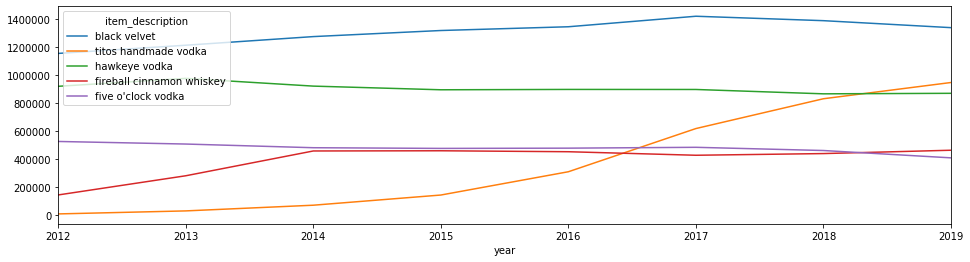

year                             2019  change_19_12_pct
item_description                                       
black velvet               1336640.48            115.94
titos handmade vodka        945500.38          11226.55
hawkeye vodka               868438.24             94.56
fireball cinnamon whiskey   462554.60            321.88
five o'clock vodka          408218.27             77.74


In [33]:
items_pivot.head(5).loc[:,2012:2019].T.plot(figsize=(16,4))
plt.show()
items_pivot['change_19_12_pct'] = round(items_pivot[2019] / items_pivot[2012] * 100, 2)
print(items_pivot.loc[:,[2019, 'change_19_12_pct']].head(5))

_2020 was excluded as it is still in progress_  
Black velvet is stable #1 item in terms of volume sold with increase of 115% in volumes sold during the period 2012 - 2019.    
#2 item - titos handmade vodka  - shows the highest growth (over 11000% during the period 2012 - 2019). For sure it should be considered as case study before launching a new product.  
Other items in top 5 have relatively stable position.

### Top vendor by volume sold

In [34]:
%%time
sql = '''
SELECT 
    EXTRACT(YEAR FROM date) AS year,
    vendor_number,
    SUM(bottles_sold) AS bottles_sold,
    SUM(sale_dollars) AS sale_dolars,
    SUM(volume_sold_liters) AS volume_sold,
FROM bigquery-public-data.iowa_liquor_sales.sales
GROUP BY 1, 2
'''

sales_by_vendors_y = client.query(sql).to_dataframe()

sql = '''
SELECT
    DISTINCT(vendor_number),
    vendor_name
FROM bigquery-public-data.iowa_liquor_sales.sales
'''
vendors_dict = client.query(sql).to_dataframe()

Wall time: 2.15 s


In [35]:
sales_by_vendors_y = sales_by_vendors_y.dropna()
vendors_dict = vendors_dict.dropna()
sales_by_vendors_y.vendor_number = sales_by_vendors_y.vendor_number.astype(int)
vendors_dict.vendor_number = vendors_dict.vendor_number.astype(int)

In [36]:
vendors_dict = vendors_dict.drop_duplicates('vendor_number')

In [37]:
vendor_pivot = sales_by_vendors_y.pivot_table(index='vendor_number', columns='year', values='volume_sold', aggfunc=sum)\
    .sort_values(by=2019, ascending=False)
vendor_pivot = pd.merge(left=vendor_pivot, right=vendors_dict, left_index=True, right_on='vendor_number', how='left')
vendor_pivot.index = vendor_pivot.vendor_name
vendor_pivot = vendor_pivot.drop(columns=['vendor_number', 'vendor_name'])

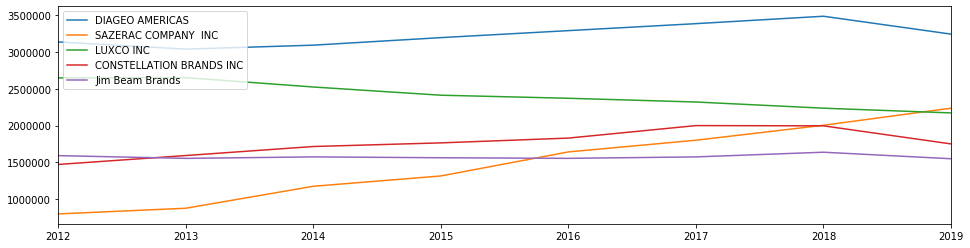

                                2019  change_19_12_pct
vendor_name                                           
DIAGEO AMERICAS           3242099.08              3.38
SAZERAC COMPANY  INC      2235576.48            179.99
LUXCO INC                 2171116.05            -17.98
CONSTELLATION BRANDS INC  1749934.24             18.99
Jim Beam Brands           1548343.71             -2.66


In [38]:
vendor_pivot.iloc[:,:8].head(5).T.plot(figsize=(16,4))
plt.legend(loc=2)
plt.show()
vendor_pivot['change_19_12_pct'] = round(vendor_pivot[2019] / vendor_pivot[2012] * 100 - 100, 2)
print(vendor_pivot.loc[:,[2019, 'change_19_12_pct']].head(5))

Historically, the most popular vendors are "Diageo Americas". Diageo Americas produce Black velvet (#1 item by volume sold), so it is not a surprise, that such a brand is the most popular.   
#2 - SAZERAC COMPANY  INC - shows the highest increase during the period 2012-2019 (+179%), while LUXCO INC and Jim Beam Brands declined by 18% and 3% respectively.
